# Práctica Final DASI
## Desarrollo de Aplicaciones y Servicios Inteligentes
## Análisis de la Producción de Electricidad
## 2023/2024
Domínguez Fernández, Roberto

Pezo Ortiz, Pablo Magno

Santoz Fernández, Jesús

## Idea/Finalidad: 
Con el uso de producciones netas de electricidad mediante el uso de energías como la nuclear, eólica o el gas natural, el mes correspondiente, el PIB de ese preciso momento y las horas de sol, viento y capacidad hidráulica: Deseamos predecir cuál debería ser la producción (GW) de energías renovables, en este caso la Solar, la Eólica y la Hidráulica.

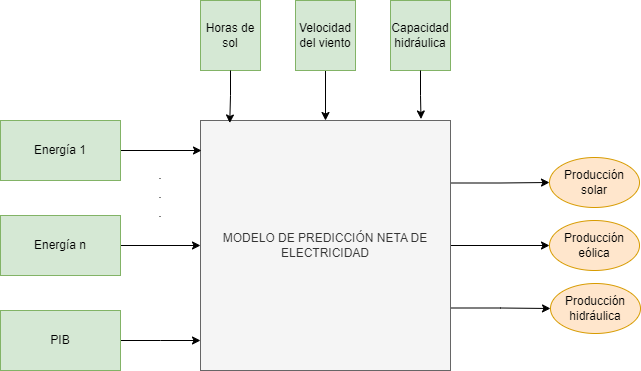

## Enlaces de los datos:
Producción de electricidad (Kaggle): https://www.kaggle.com/datasets/sazidthe1/global-electricity-production
En caso de no hacer uso de la api de kaggle, se deberá descargar el csv de los datos.

BD de la información hidráulica: https://www.miteco.gob.es/content/dam/miteco/es/agua/temas/evaluacion-de-los-recursos-hidricos/boletin-hidrologico/Historico-de-embalses/BD-Embalses.zip
Se deberá descargar el .zip que contiene la BD de los embalses. Esta BD es de Microsoft Access.

Por motivos de privacidad de datos, no se van a incluir los datos en GitHub. 

## Importación de Librerias

In [193]:
import pandas as pd
import numpy as np

from datetime import datetime
from datetime import datetime, timedelta

import os
import requests
import re
from bs4 import BeautifulSoup

from kaggle.api.kaggle_api_extended import KaggleApi #Api de Kaggle
import wbdata #Api del Banco Mundial

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import joblib #Descargar el modelo

from access_parser import AccessParser

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import load_model

import matplotlib.pyplot as plt

## Almacenamiento de los datos

### Datos de Electricidad de Kaggle

In [2]:
#Almacenamos los datos de Electricidad de Kaggle
try:
    #Nos autenticamos con la API de kaggle
    api = KaggleApi()
    api.authenticate()
    api.dataset_download_files('sazidthe1/global-electricity-production', path='.', unzip=True)
    datosElectricidad= pd.read_csv("global_electricity_production_data.csv")
except Exception as e:
    print(f"Se ha producido la siguiente excepcion: {e}")
    try:
        datosElectricidad= pd.read_csv("Datos/global_electricity_production_data.csv")
    except Exception as e:
        print(f"Se ha producido la siguiente excepcion: {e}")

## Muestreo de Datos

In [3]:
datosElectricidad

,country_name,date,parameter,product,value,unit
0,Australia,12/1/2023,Net Electricity Production,Electricity,22646.1901,GWh
1,Australia,12/1/2023,Net Electricity Production,Total Combustible Fuels,13397.9356,GWh
2,Australia,12/1/2023,Net Electricity Production,"Coal, Peat and Manufactured Gases",9768.5223,GWh
3,Australia,12/1/2023,Net Electricity Production,Oil and Petroleum Products,289.5415,GWh
4,Australia,12/1/2023,Net Electricity Production,Natural Gas,3091.9272,GWh
...,...,...,...,...,...,...
121069,United States,1/1/2010,Total Imports,Electricity,5808.5770,GWh
121070,United States,1/1/2010,Total Exports,Electricity,996.5670,GWh
121071,United States,1/1/2010,Used for pumped storage,Electricity,2283.3220,GWh
121072,United States,1/1/2010,Distribution Losses,Electricity,22933.2970,GWh


### Muestreo de los datos de Electricidad enfocados en España

In [4]:
datosElectricidad[datosElectricidad["country_name"]=="Spain"]#.head(40)

,country_name,date,parameter,product,value,unit
492,Spain,12/1/2023,Net Electricity Production,Electricity,22924.6780,GWh
493,Spain,12/1/2023,Net Electricity Production,Nuclear,4990.1643,GWh
494,Spain,12/1/2023,Net Electricity Production,Total Combustible Fuels,5660.5453,GWh
495,Spain,12/1/2023,Net Electricity Production,"Coal, Peat and Manufactured Gases",245.5875,GWh
496,Spain,12/1/2023,Net Electricity Production,Oil and Petroleum Products,805.6821,GWh
...,...,...,...,...,...,...
120976,Spain,1/1/2010,Total Imports,Electricity,755.6100,GWh
120977,Spain,1/1/2010,Total Exports,Electricity,1055.1970,GWh
120978,Spain,1/1/2010,Used for pumped storage,Electricity,566.3050,GWh
120979,Spain,1/1/2010,Distribution Losses,Electricity,2500.4510,GWh


In [5]:
#Nos quedamos con todos los valores de España
SpainDF= datosElectricidad[datosElectricidad["country_name"]=="Spain"]

#Nos quedamos solo con aquellos valores que sean de Produccion Neta de Electricidad
SpainDF = SpainDF[SpainDF["parameter"]== "Net Electricity Production"]

#Nos quedamos con las producciones que NO sean agrupaciones de producciones 
#y quitamos también Oil and Petroleum Products, porque es probable que esté contenido en Total Combustible Fuels
SpainDF = SpainDF[(SpainDF['product'] != 'Total Renewables (Hydro, Geo, Solar, Wind, Other)') & 
                  (SpainDF['product'] != 'Oil and Petroleum Products')]

#Convertimos date a tipo fecha
SpainDF = SpainDF.reset_index(drop=True)
#Convertimos string de fecha a fecha de tipo datetime
SpainDF['date'] = pd.to_datetime(SpainDF['date'])

SpainDF#[0:20]

,country_name,date,parameter,product,value,unit
0,Spain,2023-12-01,Net Electricity Production,Electricity,22924.6780,GWh
1,Spain,2023-12-01,Net Electricity Production,Nuclear,4990.1643,GWh
2,Spain,2023-12-01,Net Electricity Production,Total Combustible Fuels,5660.5453,GWh
3,Spain,2023-12-01,Net Electricity Production,"Coal, Peat and Manufactured Gases",245.5875,GWh
4,Spain,2023-12-01,Net Electricity Production,Natural Gas,4171.0379,GWh
...,...,...,...,...,...,...
1939,Spain,2010-01-01,Net Electricity Production,Other Combustible Non-Renewables,45.8970,GWh
1940,Spain,2010-01-01,Net Electricity Production,Hydro,5681.8480,GWh
1941,Spain,2010-01-01,Net Electricity Production,Wind,3908.7780,GWh
1942,Spain,2010-01-01,Net Electricity Production,Solar,273.6020,GWh


In [6]:
#Cambio de estructura de los datos, en vez de tener por cada mes y año un producto diferente
#pasaremos a tener todos los productos correspondientes a dicha fecha en la misma fila:
SpainDFMes = SpainDF.pivot(index='date', columns='product', values='value').reset_index()
#Rellenamos de 0 aquellos valores que sean NaN
SpainDFMes.fillna(0, inplace=True)
#Establecemos una nueva columna que sera el mes correspondiente (tendremos la columna date y mes)
SpainDFMes['mes'] = SpainDFMes['date'].dt.month

In [7]:
SpainDFMes

product,date,"Coal, Peat and Manufactured Gases",Combustible Renewables,Electricity,Geothermal,Hydro,Natural Gas,Not Specified,Nuclear,Other Combustible Non-Renewables,Other Renewables,Solar,Total Combustible Fuels,Wind,mes
0,2010-01-01,2114.2240,279.6320,26413.1460,0.0,5681.8480,8140.6510,11.9170,4493.1050,45.8970,0.0,273.6020,12043.8960,3908.7780,1
1,2010-02-01,1739.0210,273.0070,24351.3060,0.0,4434.7400,6986.9940,11.9170,4649.5270,44.8100,0.0,333.9060,10317.5440,4603.6720,2
2,2010-03-01,1170.5930,271.2630,25551.5790,0.0,6196.9580,6486.0650,11.9170,4876.1370,44.5240,0.0,510.3510,9355.6460,4600.5700,3
3,2010-04-01,936.4740,287.3020,21937.3510,0.0,4938.3800,6156.4490,11.9170,4908.2240,47.1560,0.0,636.5430,8717.5170,2724.7700,4
4,2010-05-01,1091.8720,340.3000,22578.6420,0.0,4030.1600,6718.0970,11.9170,4426.9270,55.8550,0.0,760.5020,9582.0250,3767.1110,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,2023-08-01,481.2385,497.6852,24130.7306,0.0,1382.1196,6238.2254,21.4167,5008.3606,48.3885,1.5,5321.6732,8128.3969,4267.2637,8
164,2023-09-01,464.6424,427.9071,21327.9661,0.0,1284.3050,6208.5075,21.4167,4546.8967,47.1226,1.5,3869.0029,8004.1878,3600.6569,9
165,2023-10-01,432.1170,405.0411,21347.8522,0.0,1934.6306,5138.1182,21.4167,3741.7979,48.3937,1.5,2932.4998,6946.3956,5769.6117,10
166,2023-11-01,255.8197,360.3426,21918.6749,0.0,3906.2181,3657.0975,21.4167,3761.3813,40.6025,1.5,2160.1744,5065.8460,7002.1385,11


# PIB

## Producto Interior Bruto Trimestral

Desde 2010 hasta 2023

https://datosmacro.expansion.com/pib/espana?anio=y

pip install beautifulsoup4
pip install requests

In [8]:
def datascrape_pib_espana(year):
    url = f"https://datosmacro.expansion.com/pib/espana?anio={year}"
    response = requests.get(url)
    
    if response.status_code == 200:
        soup = BeautifulSoup(response.text, 'html.parser')
        table = soup.find('table', {'class': 'table tabledat table-striped table-condensed table-hover'})
        
        if table:
            rows = table.find_all('tr')
            data = []
            for row in rows[1:]:  # Omitir la primera fila que contiene encabezados
                cols = row.find_all('td')
                cols = [col.text.strip() for col in cols]
                data.append(cols)
            return data
        else:
            return "No se encontró la tabla en la página."
    else:
        return "No se pudo acceder a la página."

def obtenerDatosTrimestralesPIB():
    datosPIBTrimestral=[]
    for year in range(2010, 2024):
        datosPIBTrimestral.append(datascrape_pib_espana(year))
    return datosPIBTrimestral

def obtenerDatosTrimestralesPIB_Values():
    datosPIBTrimestral= obtenerDatosTrimestralesPIB()
    datosFinalesPIB=[]
    for i in range(len(datosPIBTrimestral)):
        for j in range(len(datosPIBTrimestral[0])-1):
            #Obtenemos el valor trimestral y le quitamos la unidad (M)
            valorActualPIB= datosPIBTrimestral[i][j][1].split()[0]
            #Le quitamos el punto: yyy.yyy => yyyyyy
            valorActualPIB= int(str(valorActualPIB).replace(".", ""))
            #Al ser datos trimestrales y con el objetivo de tener valor por mes
            #se va a proceder a establecer con el mismo valor los tres primeros meses de cada trimestre
            #Al tener cuatro valores por año, podremos generar los 12 valores por año
            datosFinalesPIB.append(valorActualPIB)
            datosFinalesPIB.append(valorActualPIB)
            datosFinalesPIB.append(valorActualPIB)
    return datosFinalesPIB

PIB= obtenerDatosTrimestralesPIB_Values()

In [9]:
#Los datos estan en Millones de euros
SpainDFMes['PIB_Mensual'] = PIB
SpainDFMes

product,date,"Coal, Peat and Manufactured Gases",Combustible Renewables,Electricity,Geothermal,Hydro,Natural Gas,Not Specified,Nuclear,Other Combustible Non-Renewables,Other Renewables,Solar,Total Combustible Fuels,Wind,mes,PIB_Mensual
0,2010-01-01,2114.2240,279.6320,26413.1460,0.0,5681.8480,8140.6510,11.9170,4493.1050,45.8970,0.0,273.6020,12043.8960,3908.7780,1,269364
1,2010-02-01,1739.0210,273.0070,24351.3060,0.0,4434.7400,6986.9940,11.9170,4649.5270,44.8100,0.0,333.9060,10317.5440,4603.6720,2,269364
2,2010-03-01,1170.5930,271.2630,25551.5790,0.0,6196.9580,6486.0650,11.9170,4876.1370,44.5240,0.0,510.3510,9355.6460,4600.5700,3,269364
3,2010-04-01,936.4740,287.3020,21937.3510,0.0,4938.3800,6156.4490,11.9170,4908.2240,47.1560,0.0,636.5430,8717.5170,2724.7700,4,267959
4,2010-05-01,1091.8720,340.3000,22578.6420,0.0,4030.1600,6718.0970,11.9170,4426.9270,55.8550,0.0,760.5020,9582.0250,3767.1110,5,267959
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,2023-08-01,481.2385,497.6852,24130.7306,0.0,1382.1196,6238.2254,21.4167,5008.3606,48.3885,1.5,5321.6732,8128.3969,4267.2637,8,361861
164,2023-09-01,464.6424,427.9071,21327.9661,0.0,1284.3050,6208.5075,21.4167,4546.8967,47.1226,1.5,3869.0029,8004.1878,3600.6569,9,361861
165,2023-10-01,432.1170,405.0411,21347.8522,0.0,1934.6306,5138.1182,21.4167,3741.7979,48.3937,1.5,2932.4998,6946.3956,5769.6117,10,359848
166,2023-11-01,255.8197,360.3426,21918.6749,0.0,3906.2181,3657.0975,21.4167,3761.3813,40.6025,1.5,2160.1744,5065.8460,7002.1385,11,359848


# Energías Renovables

## Horas de Sol (Energía Solar)

### Obtención de los datos de horas solares

La url es: https://astronomia.ign.es/hora-salidas-y-puestas-de-sol

https://cdn.mitma.gob.es/portal-web-drupal/salidapuestasol/{year}/{ciudad}-{year}.txt

https://cdn.mitma.gob.es/portal-web-drupal/salidapuestasol/2020/Madrid-2020.txt

### Funciones:
Que se encargaran de generar la media por mes y año de las horas de sol de cada todas las capitales de provincia de España

In [10]:
#Funcion aux separar espacios dobles en "espacio 0 espacio"
def split_with_double_space_as_zero(line):
    # Reemplazar múltiples espacios con ' 0 ' usando expresiones regulares
    line_with_zeros = re.sub(r' {12,}', lambda m: ' 0 ' * (len(m.group(0)) // 2), line)
    # Hacer split por espacios simples
    return line_with_zeros.split()

#Tenemos el txt, se va a proceder a lo siguiente:
#Por cada fila tendremos 12 valores que corresponderan al primero de los dias de cada mes
#Estos valores de horas de sol se almacenaran para que, finalmente, puedan ser agrupados por mes
#Dia 1: 10 horas, 11 horas, 12 horas, 13 horas, 12 horas...
# ..............
#Dia n: 10 horas, 11 horas, 12 horas, 13 horas, 12 horas...
#Finalmente se agruparan por mes
#Enero: x horas en total, Febrero x horas...

#Devuelve los segundos de sol por cada dia de un mes de un año de una capital de provincia
def seg_sol_ciudad_dia_mes(url): #numeroHorasSol_CiudadYear(url):
    response = requests.get(url)
    res_total= timedelta()
    
    #Tenemos una matriz de 31 filas (los dias maximos de un mes) por los 12 meses
    matriz_timedelta = []
    
    aux_cont_ceros=0
    
    if response.status_code == 200:
        # Dividir el contenido en líneas
        lines = response.text.splitlines()
    
        for line in lines[7:31+7]:
            #print(line)
            values = split_with_double_space_as_zero(line) #line.split()
            for i in range(1, len(values), 2): # De este modo iteramos de dos horas en dos horas# values[1:]:
                value1 = values[i]
                value2 = values[i+1]

                if value1!=str(0) and value2!=str(0):
                    time_obj = datetime.strptime(value1, "%H%M")
                    time_int = time_obj.hour*3600 + time_obj.minute*60
                    #print("Objeto datetime:", time_obj)

                    time_obj2 = datetime.strptime(value2, "%H%M")
                    time_int2 = time_obj2.hour*3600 + time_obj2.minute*60
                    #print("Objeto datetime:", time_obj2)

                    res= time_obj2 - time_obj
                    res_int= time_int2-time_int

                    matriz_timedelta.append(res_int)
                else:
                    #Por motivos que se desconocen en vez de imprimir un 0 si no hay dia en ese mes 
                    #(no existe el 30 de febrero por ejemplo) imprime 3. Asique se va a asegurar que solo imprima uno
                    aux_cont_ceros = aux_cont_ceros+1
                    if aux_cont_ceros==3:
                        matriz_timedelta.append(0)
                        aux_cont_ceros=0
    else:
        print(f'Error al acceder al archivo: {response.status_code}')
    
    return matriz_timedelta
m= seg_sol_ciudad_dia_mes('https://cdn.mitma.gob.es/portal-web-drupal/salidapuestasol/2011/Madrid-2011.txt')

#Devuelve el sumatorio de horas de sol en segundos por cada mes. Array de 12 elementos
def seg_sol_ciudad_mes(seg_dias_ciudad): #sumatorio_horasSol(matriz_timedelta):
    i=0
    j=0
    
    meses = [0] * 12
    
    for i in range(len(m)):
        meses[j] = meses[j] + m[i]
        j=j+1
        if j==12:
            j=0
    return meses

meses= seg_sol_ciudad_mes(m)
print(meses)

#Lo hacemos por cada ciudad y por cada año
def seg_sol_ciudad_year():
    ciudades_values = [[None] * 14 for _ in range(52)]

    # Array de ciudades
    ciudades = [
        "Almeria", "Cadiz", "Cordoba", "Granada", "Huelva", "Jaen", "Malaga", "Sevilla",
        "Huesca", "Teruel", "Zaragoza",
        "Oviedo",  # Asturias
        "Palma",  # Balears, Illes
        "Palmas", "Santa", #Las Palmas de Gran Canaria por Palmas y Santa Cruz de Tenerife por Santa
        "Santander",  # Cantabria
        "Avila", "Burgos", "Leon", "Palencia", "Salamanca", "Segovia", "Soria", "Valladolid", "Zamora",
        "Albacete", "Ciudad", "Cuenca", "Guadalajara", "Toledo", #Ciudad como Ciudad Real
        "Barcelona", "Girona", "Lleida", "Tarragona",
        "Alicante", "Castellon", "Valencia",
        "Badajoz", "Caceres",
        "Coruna", "Lugo", "Ourense", "Pontevedra", #A Coruña por Coruna
        "Madrid",
        "Murcia",
        "Pamplona",  # Navarra
        "Vitoria",  # Alava
        "Donostia",  # Gipuzkoa. Aunque la capital es San Sebastian, la medicion es en Donostia
        "Bilbao",  # Bizkaia
        "Logrono",  # La Rioja
        "Ceuta", "Melilla"
    ]

    #print(len(ciudades))

    # Rango de años
    start_year = 2010
    end_year = 2023

    # URL base
    base_url = "https://cdn.mitma.gob.es/portal-web-drupal/salidapuestasol"

    i=0
    j=0

    for ciudad in ciudades:
        #print(ciudad)
        for year in range(start_year, end_year + 1):
            url = f"{base_url}/{year}/{ciudad}-{year}.txt"
            m= seg_sol_ciudad_dia_mes(url)
            meses= seg_sol_ciudad_mes(m)
            ciudades_values[i][j]= meses
            j=j+1
        i=i+1
        j=0
    return ciudades_values

#Una vez hemos obtenido por cada ciudad y año los valores mensuales de horas de sol
#como nuestro modelo esta en funcion de pais y no de comunidades autonomas o provincias se va a llevar a cabo
#una media de los valores

#cv[0][0][0] sería la ciudad 0 en el primero de los años (2010) en el primero de los meses
#por lo que se va a coger la media para todas las ciudades en cada año y por mes
def calcular_media_anual_mensual():
    cv= seg_sol_ciudad_year()
    # Crear un array para almacenar las medias: dimensiones (13, 12)
    num_anos = len(cv[0])
    num_meses = len(cv[0][0])
    medias = np.zeros((num_anos, num_meses))
    
    # Recorrer años y meses para calcular las medias
    for ano in range(num_anos):  # len(data[0]) da el número de años
        for mes in range(num_meses):  # len(data[0][0]) da el número de meses
            # Extraer todos los valores para un año y mes específicos
            valores = [cv[pais][ano][mes] for pais in range(len(cv))]
            # Calcular la media de esos valores
            medias[ano, mes] = np.mean(valores)
    
    return medias

[1078380, 1074900, 1333020, 1434540, 1609680, 1621020, 1644000, 1533720, 1346160, 1242600, 1076100, 1043100]


In [11]:
horasSolMedias= calcular_media_anual_mensual()

In [12]:
#Pasamos de array[14][12] => array[14*12] para poder almacenar facilmente los 168 valores
datos_aplanados_horasSol = horasSolMedias.flatten()
SpainDFMes['horas_sol_mes'] = datos_aplanados_horasSol
SpainDFMes

product,date,"Coal, Peat and Manufactured Gases",Combustible Renewables,Electricity,Geothermal,Hydro,Natural Gas,Not Specified,Nuclear,Other Combustible Non-Renewables,Other Renewables,Solar,Total Combustible Fuels,Wind,mes,PIB_Mensual,horas_sol_mes
0,2010-01-01,2114.2240,279.6320,26413.1460,0.0,5681.8480,8140.6510,11.9170,4493.1050,45.8970,0.0,273.6020,12043.8960,3908.7780,1,269364,1078380.0
1,2010-02-01,1739.0210,273.0070,24351.3060,0.0,4434.7400,6986.9940,11.9170,4649.5270,44.8100,0.0,333.9060,10317.5440,4603.6720,2,269364,1074900.0
2,2010-03-01,1170.5930,271.2630,25551.5790,0.0,6196.9580,6486.0650,11.9170,4876.1370,44.5240,0.0,510.3510,9355.6460,4600.5700,3,269364,1333020.0
3,2010-04-01,936.4740,287.3020,21937.3510,0.0,4938.3800,6156.4490,11.9170,4908.2240,47.1560,0.0,636.5430,8717.5170,2724.7700,4,267959,1434540.0
4,2010-05-01,1091.8720,340.3000,22578.6420,0.0,4030.1600,6718.0970,11.9170,4426.9270,55.8550,0.0,760.5020,9582.0250,3767.1110,5,267959,1609680.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,2023-08-01,481.2385,497.6852,24130.7306,0.0,1382.1196,6238.2254,21.4167,5008.3606,48.3885,1.5,5321.6732,8128.3969,4267.2637,8,361861,1533720.0
164,2023-09-01,464.6424,427.9071,21327.9661,0.0,1284.3050,6208.5075,21.4167,4546.8967,47.1226,1.5,3869.0029,8004.1878,3600.6569,9,361861,1346160.0
165,2023-10-01,432.1170,405.0411,21347.8522,0.0,1934.6306,5138.1182,21.4167,3741.7979,48.3937,1.5,2932.4998,6946.3956,5769.6117,10,359848,1242600.0
166,2023-11-01,255.8197,360.3426,21918.6749,0.0,3906.2181,3657.0975,21.4167,3761.3813,40.6025,1.5,2160.1744,5065.8460,7002.1385,11,359848,1076100.0


## Media de velocidad de Viento (Energía Eólica)

### Obtención datos de viento por mes

https://datosclima.es/Aemethistorico/Viento.php

La obtención de los datos se hará manualmente debido a que no es viable hacer web scrapping por la predisposición de la página.
Se usará una ciudad como total medio de viento en España

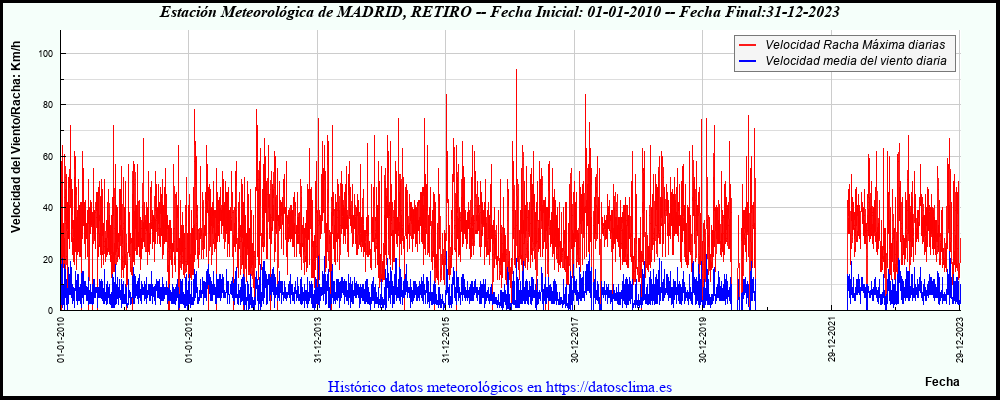

In [13]:
#Los datos corresponden a Madrid. Debido a la complejidad de obtener los datos, se ha decidido usar
#unicamente los datos de viento de una ciudad como media de España
datos_viento = [6.668, 7.254, 7.182, 6.246, 6.412, 6.564, 7.244, 7.42, 6.978, 6.426, 7.392, 6.672,  #2010
                5.605, 7.848, 8.947, 7.807, 7.696, 7.793, 7.843, 7.64, 6.888, 7.332, 5.813, 5.097,  #2011
                5.077, 6.716, 7.439, 7.506, 6.940, 6.407, 6.976, 7.093, 7.122, 6.864, 7.419, 5.987, #2012
                6.73, 8.15, 8.16, 8.12, 7.91, 7.78, 7.94, 7.77, 7.17, 7.38, 6.83, 7.42,             #2013
                7.40, 7.50, 8.07, 7.32, 7.83, 7.35, 7.54, 7.66, 7.45, 7.14, 7.00, 5.95,             #2014
                5.14, 7.27, 6.67, 7.27, 7.27, 6.93, 7.15, 6.93, 6.60, 7.06, 4.93, 3.78,             #2015
                5.66, 6.78, 6.49, 6.89, 6.45, 6.50, 7.35, 6.63, 5.66, 4.96, 4.77, 4.32,             #2016
                4.80, 4.92, 5.76, 5.76, 6.24, 6.42, 7.26, 6.87, 5.34, 5.73, 4.96, 6.54,             #2017
                6.272, 8.866, 10.597, 7.619, 6.941, 6.964, 7.457, 6.794, 6.594, 5.450, 5.835, 4.769,#2018
                6.964, 6.640, 7.610, 7.164, 7.432, 7.208, 7.872, 8.092, 7.976, 8.224, 8.036, 8.124, #2019
                5.26, 5.38, 7.12, 7.07, 6.57, 6.79, 8.15, 9.43, 7.67, 8.08, 8.03, 8.12,             #2020,no hay datos nov/dic
                5.26, 5.38, 7.12, 7.07, 6.57, 6.79, 8.15, 9.43, 7.67, 8.08, 8.03, 8.12,             #2021 NINGUN DATO
                5.26, 5.38, 7.12, 9.85, 9.45, 9.10, 10.39, 8.85, 8.96, 8.29, 9.85, 7.94,            #2022, no datos en/feb/mar
                6.51, 6.35, 7.77, 7.72, 6.95, 7.41, 8.35, 7.35, 6.34, 6.41, 6.92, 5.43]             #2023

SpainDFMes['viento_medio_mes'] = datos_viento
SpainDFMes

product,date,"Coal, Peat and Manufactured Gases",Combustible Renewables,Electricity,Geothermal,Hydro,Natural Gas,Not Specified,Nuclear,Other Combustible Non-Renewables,Other Renewables,Solar,Total Combustible Fuels,Wind,mes,PIB_Mensual,horas_sol_mes,viento_medio_mes
0,2010-01-01,2114.2240,279.6320,26413.1460,0.0,5681.8480,8140.6510,11.9170,4493.1050,45.8970,0.0,273.6020,12043.8960,3908.7780,1,269364,1078380.0,6.668
1,2010-02-01,1739.0210,273.0070,24351.3060,0.0,4434.7400,6986.9940,11.9170,4649.5270,44.8100,0.0,333.9060,10317.5440,4603.6720,2,269364,1074900.0,7.254
2,2010-03-01,1170.5930,271.2630,25551.5790,0.0,6196.9580,6486.0650,11.9170,4876.1370,44.5240,0.0,510.3510,9355.6460,4600.5700,3,269364,1333020.0,7.182
3,2010-04-01,936.4740,287.3020,21937.3510,0.0,4938.3800,6156.4490,11.9170,4908.2240,47.1560,0.0,636.5430,8717.5170,2724.7700,4,267959,1434540.0,6.246
4,2010-05-01,1091.8720,340.3000,22578.6420,0.0,4030.1600,6718.0970,11.9170,4426.9270,55.8550,0.0,760.5020,9582.0250,3767.1110,5,267959,1609680.0,6.412
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,2023-08-01,481.2385,497.6852,24130.7306,0.0,1382.1196,6238.2254,21.4167,5008.3606,48.3885,1.5,5321.6732,8128.3969,4267.2637,8,361861,1533720.0,7.350
164,2023-09-01,464.6424,427.9071,21327.9661,0.0,1284.3050,6208.5075,21.4167,4546.8967,47.1226,1.5,3869.0029,8004.1878,3600.6569,9,361861,1346160.0,6.340
165,2023-10-01,432.1170,405.0411,21347.8522,0.0,1934.6306,5138.1182,21.4167,3741.7979,48.3937,1.5,2932.4998,6946.3956,5769.6117,10,359848,1242600.0,6.410
166,2023-11-01,255.8197,360.3426,21918.6749,0.0,3906.2181,3657.0975,21.4167,3761.3813,40.6025,1.5,2160.1744,5065.8460,7002.1385,11,359848,1076100.0,6.920


## Total Agua Disponible (Energía Hidraúlica)

https://www.miteco.gob.es/es/agua/temas/evaluacion-de-los-recursos-hidricos/boletin-hidrologico.html

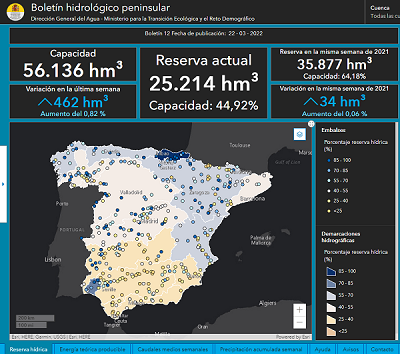

In [14]:
#!pip install access-parser
##https://github.com/claroty/access_parser
# .mdb or .accdb file
db = AccessParser("BD-Embalses.mdb")

# Tables are stored as defaultdict(list) -- table[column][row_index]
table = db.parse_table("T_Datos")

#Generamos el dataframe con los datos de fecha embalse y agua en ese momento
hidraulica = pd.DataFrame({"FECHA": table["FECHA"], "EMBALSE": table["EMBALSE_NOMBRE"], "AGUA_ACTUAL": table["AGUA_ACTUAL"]})

# Convertir la columna "FECHA" al tipo datetime
hidraulica['FECHA'] = pd.to_datetime(hidraulica['FECHA'])
# Convertir la columna "AGUA_ACTUAL" al tipo float
hidraulica['AGUA_ACTUAL'] = hidraulica['AGUA_ACTUAL'].str.replace(',', '.').astype(float)

#Seleccionamos los datos desde 2010 hasta 2023
hidraulica_2010_2023 = hidraulica[(hidraulica['FECHA'] >= '2010-01-01') & (hidraulica['FECHA'] <= '2023-12-12')]
#Reseteo de indices
hidraulica_2010_2023 = hidraulica_2010_2023.reset_index(drop=True)

In [15]:
#Generamos dos nuevas columnas, Año y Mes
hidraulica_2010_2023['YEAR'] = hidraulica_2010_2023['FECHA'].dt.year
hidraulica_2010_2023['MES'] = hidraulica_2010_2023['FECHA'].dt.month

#AGRUPAR POR MES Y AÑO POR CADA EMBALSE, QUEDANDONOS UNICAMENTE 
#CON EL DATO MAXIMO POR MES Y AÑO DE CADAE EMBALSE
hidraulica_2010_2023_max = hidraulica_2010_2023.groupby(
    ['EMBALSE', 'YEAR', 'MES']).agg({'AGUA_ACTUAL': 'max'})
#AGRUPAR POR MES Y AÑO MEDIO DE TODOS LOS EMBALSES CON LOS DATOS
#MAX MENSUALES OBTENIDOS
hidraulica_2010_2023_sum = pd.pivot_table(
    hidraulica_2010_2023_max, values='AGUA_ACTUAL', 
    index='YEAR', columns='MES', aggfunc='sum', fill_value=0)

hidraulica_2010_2023_sum_final = hidraulica_2010_2023_sum.values.flatten().tolist()

In [16]:
SpainDFMes['hidraulica_disponible_mes'] = hidraulica_2010_2023_sum_final
SpainDFMes

product,date,"Coal, Peat and Manufactured Gases",Combustible Renewables,Electricity,Geothermal,Hydro,Natural Gas,Not Specified,Nuclear,Other Combustible Non-Renewables,Other Renewables,Solar,Total Combustible Fuels,Wind,mes,PIB_Mensual,horas_sol_mes,viento_medio_mes,hidraulica_disponible_mes
0,2010-01-01,2114.2240,279.6320,26413.1460,0.0,5681.8480,8140.6510,11.9170,4493.1050,45.8970,0.0,273.6020,12043.8960,3908.7780,1,269364,1078380.0,6.668,37976
1,2010-02-01,1739.0210,273.0070,24351.3060,0.0,4434.7400,6986.9940,11.9170,4649.5270,44.8100,0.0,333.9060,10317.5440,4603.6720,2,269364,1074900.0,7.254,40701
2,2010-03-01,1170.5930,271.2630,25551.5790,0.0,6196.9580,6486.0650,11.9170,4876.1370,44.5240,0.0,510.3510,9355.6460,4600.5700,3,269364,1333020.0,7.182,46078
3,2010-04-01,936.4740,287.3020,21937.3510,0.0,4938.3800,6156.4490,11.9170,4908.2240,47.1560,0.0,636.5430,8717.5170,2724.7700,4,267959,1434540.0,6.246,46804
4,2010-05-01,1091.8720,340.3000,22578.6420,0.0,4030.1600,6718.0970,11.9170,4426.9270,55.8550,0.0,760.5020,9582.0250,3767.1110,5,267959,1609680.0,6.412,47233
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,2023-08-01,481.2385,497.6852,24130.7306,0.0,1382.1196,6238.2254,21.4167,5008.3606,48.3885,1.5,5321.6732,8128.3969,4267.2637,8,361861,1533720.0,7.350,23771
164,2023-09-01,464.6424,427.9071,21327.9661,0.0,1284.3050,6208.5075,21.4167,4546.8967,47.1226,1.5,3869.0029,8004.1878,3600.6569,9,361861,1346160.0,6.340,21287
165,2023-10-01,432.1170,405.0411,21347.8522,0.0,1934.6306,5138.1182,21.4167,3741.7979,48.3937,1.5,2932.4998,6946.3956,5769.6117,10,359848,1242600.0,6.410,21776
166,2023-11-01,255.8197,360.3426,21918.6749,0.0,3906.2181,3657.0975,21.4167,3761.3813,40.6025,1.5,2160.1744,5065.8460,7002.1385,11,359848,1076100.0,6.920,25177


# Entrenamiento

## Modelo de Regresion

In [143]:
# Función para entrenar el modelo de regresión para un país dado
# No se va a hacer uso de los valores de energias geotermales debido a los pocos datos encontrados
def train_regression_model():    
    caracteristicas = ['Coal, Peat and Manufactured Gases', 'Combustible Renewables', 'Electricity', 
                       'Natural Gas', 'Not Specified', 'Nuclear', 'Other Combustible Non-Renewables',
                       'Total Combustible Fuels', 'mes', 'PIB_Mensual', 
                       'horas_sol_mes', 'viento_medio_mes', 'hidraulica_disponible_mes']
    prediccion = ['Hydro', 'Solar', 'Wind']
    
    X = SpainDFMes[caracteristicas]
    y = SpainDFMes[prediccion]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=36)
    model = LinearRegression()

    model.fit(X_train, y_train)

    predictions = model.predict(X_test)
    
    return model, X_test, predictions

In [144]:
modelo, entr, pred= train_regression_model()

In [145]:
x_val= [2114.2240, 279.6320, 26413.1460, 8140.6510, 11.9170, 4493.1050, 45.8970, 12043.8960, 1, 269364 , 1078380.0, 6.668, 37976]
y_val= [5681.8480, 273.6020, 3908.7780]

y_pred = modelo.predict(np.array(x_val).reshape(1, -1))
y_pred

array([[4574.61335488,   50.91807353, 5238.59583987]])

### Guardamos el modelo

In [146]:
joblib.dump(modelo, 'modelo.pkl')

['modelo.pkl']

## Red Neuronal

In [209]:
model = Sequential()

model.add(Dense(32, input_dim=13, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(3, activation='linear'))

model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_98 (Dense)            (None, 32)                448       
                                                                 
 dense_99 (Dense)            (None, 64)                2112      
                                                                 
 dense_100 (Dense)           (None, 12)                780       
                                                                 
 dense_101 (Dense)           (None, 3)                 39        
                                                                 
Total params: 3,379
Trainable params: 3,379
Non-trainable params: 0
_________________________________________________________________


In [210]:
caracteristicas = ['Coal, Peat and Manufactured Gases', 'Combustible Renewables', 'Electricity', 
                   'Natural Gas', 'Not Specified', 'Nuclear', 'Other Combustible Non-Renewables',
                   'Total Combustible Fuels', 'mes', 'PIB_Mensual', 
                   'horas_sol_mes', 'viento_medio_mes', 'hidraulica_disponible_mes']
prediccion = ['Hydro', 'Solar', 'Wind']

entrada = SpainDFMes[caracteristicas].iloc[:150]
X = entrada.to_numpy()

salida = SpainDFMes[prediccion].iloc[:150]
y = salida.to_numpy()

entrada_val = SpainDFMes[caracteristicas].iloc[150:]
X_val = entrada_val.to_numpy()

salida_val = SpainDFMes[prediccion].iloc[150:]
y_val = salida_val.to_numpy()

Epoch 1/150
9/9 [==============================] - 0s 10ms/step - loss: 38734741504.0000 - val_loss: 10099066880.0000
Epoch 2/150
9/9 [==============================] - 0s 3ms/step - loss: 3541831936.0000 - val_loss: 242507920.0000
Epoch 3/150
9/9 [==============================] - 0s 3ms/step - loss: 255471200.0000 - val_loss: 438686784.0000
Epoch 4/150
9/9 [==============================] - 0s 3ms/step - loss: 369382816.0000 - val_loss: 413809248.0000
Epoch 5/150
9/9 [==============================] - 0s 3ms/step - loss: 309255872.0000 - val_loss: 303469536.0000
Epoch 6/150
9/9 [==============================] - 0s 3ms/step - loss: 277722112.0000 - val_loss: 266569984.0000
Epoch 7/150
9/9 [==============================] - 0s 3ms/step - loss: 232694384.0000 - val_loss: 251739248.0000
Epoch 8/150
9/9 [==============================] - 0s 3ms/step - loss: 198032352.0000 - val_loss: 216403776.0000
Epoch 9/150
9/9 [==============================] - 0s 3ms/step - loss: 165768864.0000 - va

9/9 [==============================] - 0s 3ms/step - loss: 1450704.1250 - val_loss: 5646264.0000
Epoch 149/150
9/9 [==============================] - 0s 3ms/step - loss: 1464918.2500 - val_loss: 6820787.5000
Epoch 150/150
9/9 [==============================] - 0s 3ms/step - loss: 1547036.5000 - val_loss: 5133272.0000


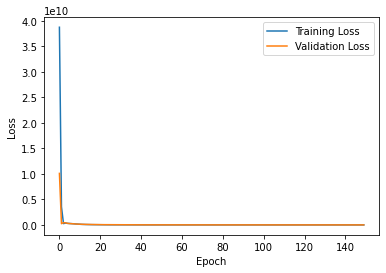

In [211]:
history = model.fit(X, y, epochs=150, batch_size=17, validation_data=(X_val, y_val))

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [212]:
x_val= [2114.2240, 279.6320, 26413.1460, 8140.6510, 11.9170, 4493.1050, 45.8970, 12043.8960, 1, 269364 , 1078380.0, 6.668, 37976]
y_val= [5681.8480, 273.6020, 3908.7780]

y_pred = model.predict(np.array(x_val).reshape(1, -1))
y_pred

array([[2146.1445 ,  335.91943, 3454.827  ]], dtype=float32)

### Guardamos el modelo

In [213]:
model.save('modelo_RN.h5')